In [1]:
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['DejaVu Sans'],'size':12})
rc('mathtext',**{'default':'regular'})
get_ipython().run_line_magic('matplotlib', 'inline')
get_ipython().run_line_magic('config', "InlineBackend.figure_format = 'retina'")

#import math packages
import numpy as np
from scipy.optimize import fsolve
from scipy.optimize import curve_fit 
from pickle import dump, load
import pandas as pd
import torch

import warnings
warnings.filterwarnings('ignore')

In [2]:
#load SOPR potentials and compute σ and WCA decomposition for hard-particle radius calculation

#neon
input_dict = load(open('data/results/ne_sopr42K.p', 'rb'))
r_ne = input_dict['sopr_r']
v_ne = input_dict['pot']
ne_rdf_sopr = input_dict['rdf']
ne_r_exp    = input_dict['exp_r']
ne_rdf_exp  = input_dict['exp_rdf']
r_wca_ne = r_ne[np.argmin(v_ne)]
wca_ne     = list()
att_ne     = list()
for i in range (len(r_ne)):
    if r_ne[i] <= r_wca_ne:
        wca_ne.append(v_ne[i] - np.min(v_ne))
        att_ne.append(np.min(v_ne))
    else:
        wca_ne.append(0)
        att_ne.append(v_ne[i])

#argon
input_dict = load(open('data/results/ar_sopr85K.p', 'rb'))
r_ar = input_dict['sopr_r']
v_ar = input_dict['pot']
ar_rdf_sopr = input_dict['rdf']
ar_r_exp    = input_dict['exp_r']
ar_rdf_exp  = input_dict['exp_rdf']
r_wca_ar = r_ar[np.argmin(v_ar)]
wca_ar     = list()
att_ar     = list()
for i in range (len(r_ar)):
    if r_ar[i] <= r_wca_ar:
        wca_ar.append(v_ar[i] - np.min(v_ar))
        att_ar.append(np.min(v_ar))
    else:
        wca_ar.append(0)
        att_ar.append(v_ar[i])

#krypton
input_dict = load(open('data/results/kr_sopr199K.p', 'rb'))
r_kr = input_dict['sopr_r']
v_kr = input_dict['pot']
kr_rdf_sopr = input_dict['rdf']
kr_r_exp    = input_dict['exp_r']
kr_rdf_exp  = input_dict['exp_rdf']
r_wca_kr = r_kr[np.argmin(v_kr)]
wca_kr     = list()
att_kr     = list()
for i in range (len(r_kr)):
    if r_kr[i] <= r_wca_kr:
        wca_kr.append(v_kr[i] - np.min(v_kr))
        att_kr.append(np.min(v_kr))
    else:
        wca_kr.append(0)
        att_kr.append(v_kr[i])
        
#xenon       
input_dict = load(open('data/results/xe_sopr274K.p', 'rb'))
r_xe = input_dict['sopr_r']
v_xe = input_dict['pot']
xe_rdf_sopr = input_dict['rdf']
xe_r_exp    = input_dict['exp_r']
xe_rdf_exp  = input_dict['exp_rdf']
r_wca_xe = r_xe[np.argmin(v_xe)]
wca_xe     = list()
att_xe     = list()
for i in range (len(r_xe)):
    if r_xe[i] <= r_wca_xe:
        wca_xe.append(v_xe[i] - np.min(v_xe))
        att_xe.append(np.min(v_xe))
    else:
        wca_xe.append(0)
        att_xe.append(v_xe[i])

#define potential properties for later analysis
sopr_vdW_radii = np.array([r_wca_ne, r_wca_ar, r_wca_kr, r_wca_xe]) #vdW radius from SOPR [Å]
α = np.array([2.67, 11.1, 16.8, 27.3])*(0.529177**3)                #polarizability [Å^3]
r_sop = np.array([2.77, 3.40, 3.58, 3.91])                          #SOPR σ [Å]
ϵ_sop = np.array([att_ne[0], att_ar[0], att_kr[0], att_xe[0]])*-1
r_vdw = np.array([2.91, 3.55, 3.82,4.08])*0.529177                  #vdW radius from DFT [Å]

In [3]:
#compute the approximate hard particle radius 
k   = 3.29982916e-27    #boltzmann constant, [kcal/K/particle]
av  = 6.0223e23         #avagadro number,    [particle/mol]

def hard_particle(r, rd):
    v = torch.zeros_like(torch.tensor(r))
    for i in range (len(r)):
        if r[i] < rd:
            v[i] = np.infty
        else:
            v[i] = 0
    return v

#neon
T   = 42.2              #temperature,        [K]
kbT = k * av * T        #thermal energy,     [kcal/mol]
hp_ne = np.trapz(1-np.exp((-1/kbT)*np.array(wca_ne)), r_ne) + r_ne[0]
bf_ne = torch.exp(-1*torch.tensor(wca_ne)/kbT)
bf_hp_ne = torch.exp(-1*torch.tensor(hard_particle(r_ne, hp_ne)/kbT))
blip_ne = bf_ne - bf_hp_ne

#argon
T   = 85.               #temperature,        [K]
kbT = k * av * T        #thermal energy,     [kcal/mol]
hp_ar = np.trapz(1-np.exp((-1/kbT)*np.array(wca_ar)), r_ar) + r_ar[0]
bf_ar = torch.exp(-1*torch.tensor(wca_ar)/kbT)
bf_hp_ar = torch.exp(-1*torch.tensor(hard_particle(r_ar, hp_ar)/kbT))
blip_ar = bf_ar - bf_hp_ar

#krypton
T   = 199.              #temperature,        [K]
kbT = k * av * T        #thermal energy,     [kcal/mol]
hp_kr = np.trapz(1-np.exp((-1/kbT)*np.array(wca_kr)), r_kr) + r_kr[0]
bf_kr = torch.exp(-1*torch.tensor(wca_kr)/kbT)
bf_hp_kr = torch.exp(-1*torch.tensor(hard_particle(r_kr, hp_kr)/kbT))
blip_kr = bf_kr - bf_hp_kr

#xenon
T   = 274.               #temperature,        [K]
kbT = k * av * T        #thermal energy,     [kcal/mol]
hp_xe = np.trapz(1-np.exp((-1/kbT)*np.array(wca_xe)), r_xe) + r_xe[0]
bf_xe = torch.exp(-1*torch.tensor(wca_xe)/kbT)
bf_hp_xe = torch.exp(-1*torch.tensor(hard_particle(r_xe, hp_xe)/kbT))
blip_xe = bf_xe - bf_hp_xe

hp    = [hp_ne, hp_ar, hp_kr, hp_xe]             #WCA hard-particle radius [Å]
bf    = [bf_ne, bf_ar, bf_kr, bf_xe]             #boltzmann factor
bf_hp = [bf_hp_ne, bf_hp_ar, bf_hp_kr, bf_hp_xe] #hard-particle boltzmann factor
blip  = [blip_ne, blip_ar, blip_kr, blip_xe]     #blip function

In [4]:
#quantum drude oscillator polarizability model
def quan_drude(p, c):
    return c*np.power(p,1/7)

#learn hard-particle QDO constant
x_data = α
y_data = hp
params_hp, params_covariance_hp = curve_fit(quan_drude, x_data, y_data)
y_fit = quan_drude(x_data, *params_hp)
ss_res = np.sum((y_data - y_fit) ** 2)
ss_tot = np.sum((y_data - np.mean(y_data)) ** 2)
r_squared = 1 - (ss_res / ss_tot)
print("HP QDO Parameter:", params_hp)
print("HP QDO R^2:", r_squared)

#learn σ QDO constant
x_data = α
y_data = r_sop
params_sopr, params_covariance_sopr = curve_fit(quan_drude, x_data, y_data)
y_fit = quan_drude(x_data, *params_sopr)
ss_res = np.sum((y_data - y_fit) ** 2)
ss_tot = np.sum((y_data - np.mean(y_data)) ** 2)
r_squared = 1 - (ss_res / ss_tot)
print("σ QDO Parameter:", params_sopr)
print("σ QDO R^2:", r_squared)

#unit conversion on Federov et. al. QDO constant for vdW radius
param_vdw = 2*2.54*(1/.529)**(-4/7)
print("vdW QDO Parameter:", param_vdw)

HP QDO Parameter: [3.2282915]
HP QDO R^2: 0.9938645234704324
σ QDO Parameter: [3.17063615]
σ QDO R^2: 0.9962438214073563
vdW QDO Parameter: 3.5305176095815307


In [5]:
#compare to existing classical force fields for noble gases He and Rn
atom_name   = ['He', 'Rn']
atom_pola   = np.array([0.208, 4.965]) # Å^3
hp_rad      = params_hp*np.power(atom_pola,1/7)
sopr_rad    = params_sopr*np.power(atom_pola,1/7)
ff_trained  = np.array([2.5238, 4.145])
disp        = np.array([np.min(v_ne),np.min(v_ar),np.min(v_kr),np.min(v_xe)])
disp_ff     = np.array([0.0019872041*10.22, 0.0019872041*292])
sopr_ϵ      = 0.15*atom_pola**0.865         
error_σ     = (sopr_rad - ff_trained)/ff_trained*100
error_ϵ     = (sopr_ϵ - disp_ff)/disp_ff*100

print('Atom Name', atom_name)
print('σ Error (%)', error_σ)
print('ϵ Error (%)', error_ϵ)
print("SOPR ϵ", sopr_ϵ )
print("FF ϵ", disp_ff)
print(disp_ff)

Atom Name ['He', 'Rn']
σ Error (%) [ 0.38572202 -3.83015683]
ϵ Error (%) [89.89899812  3.37989501]
SOPR ϵ [0.03856702 0.5998759 ]
FF ϵ [0.02030923 0.5802636 ]
[0.02030923 0.5802636 ]


In [6]:
mick_σ = np.array([2.794, 3.405, 3.645, 3.964])
mick_ϵ = np.array([32.3, 122.1, 176.1, 243.8])*0.0019872041
print(ϵ_sop)
print(mick_ϵ)
#percent error for Ne, Ar, Kr, Xe with Mick 2015
print((quan_drude(α, 3.16) - mick_σ)/mick_σ*100)
print((ϵ_sop - mick_ϵ)/mick_ϵ*100)

[0.06513107 0.24249553 0.34190178 0.46934111]
[0.06418669 0.24263762 0.34994664 0.48448036]
[-0.93183255 -0.35739132 -1.24092773 -2.66639749]
[ 1.47129532 -0.05855975 -2.29888271 -3.12484308]


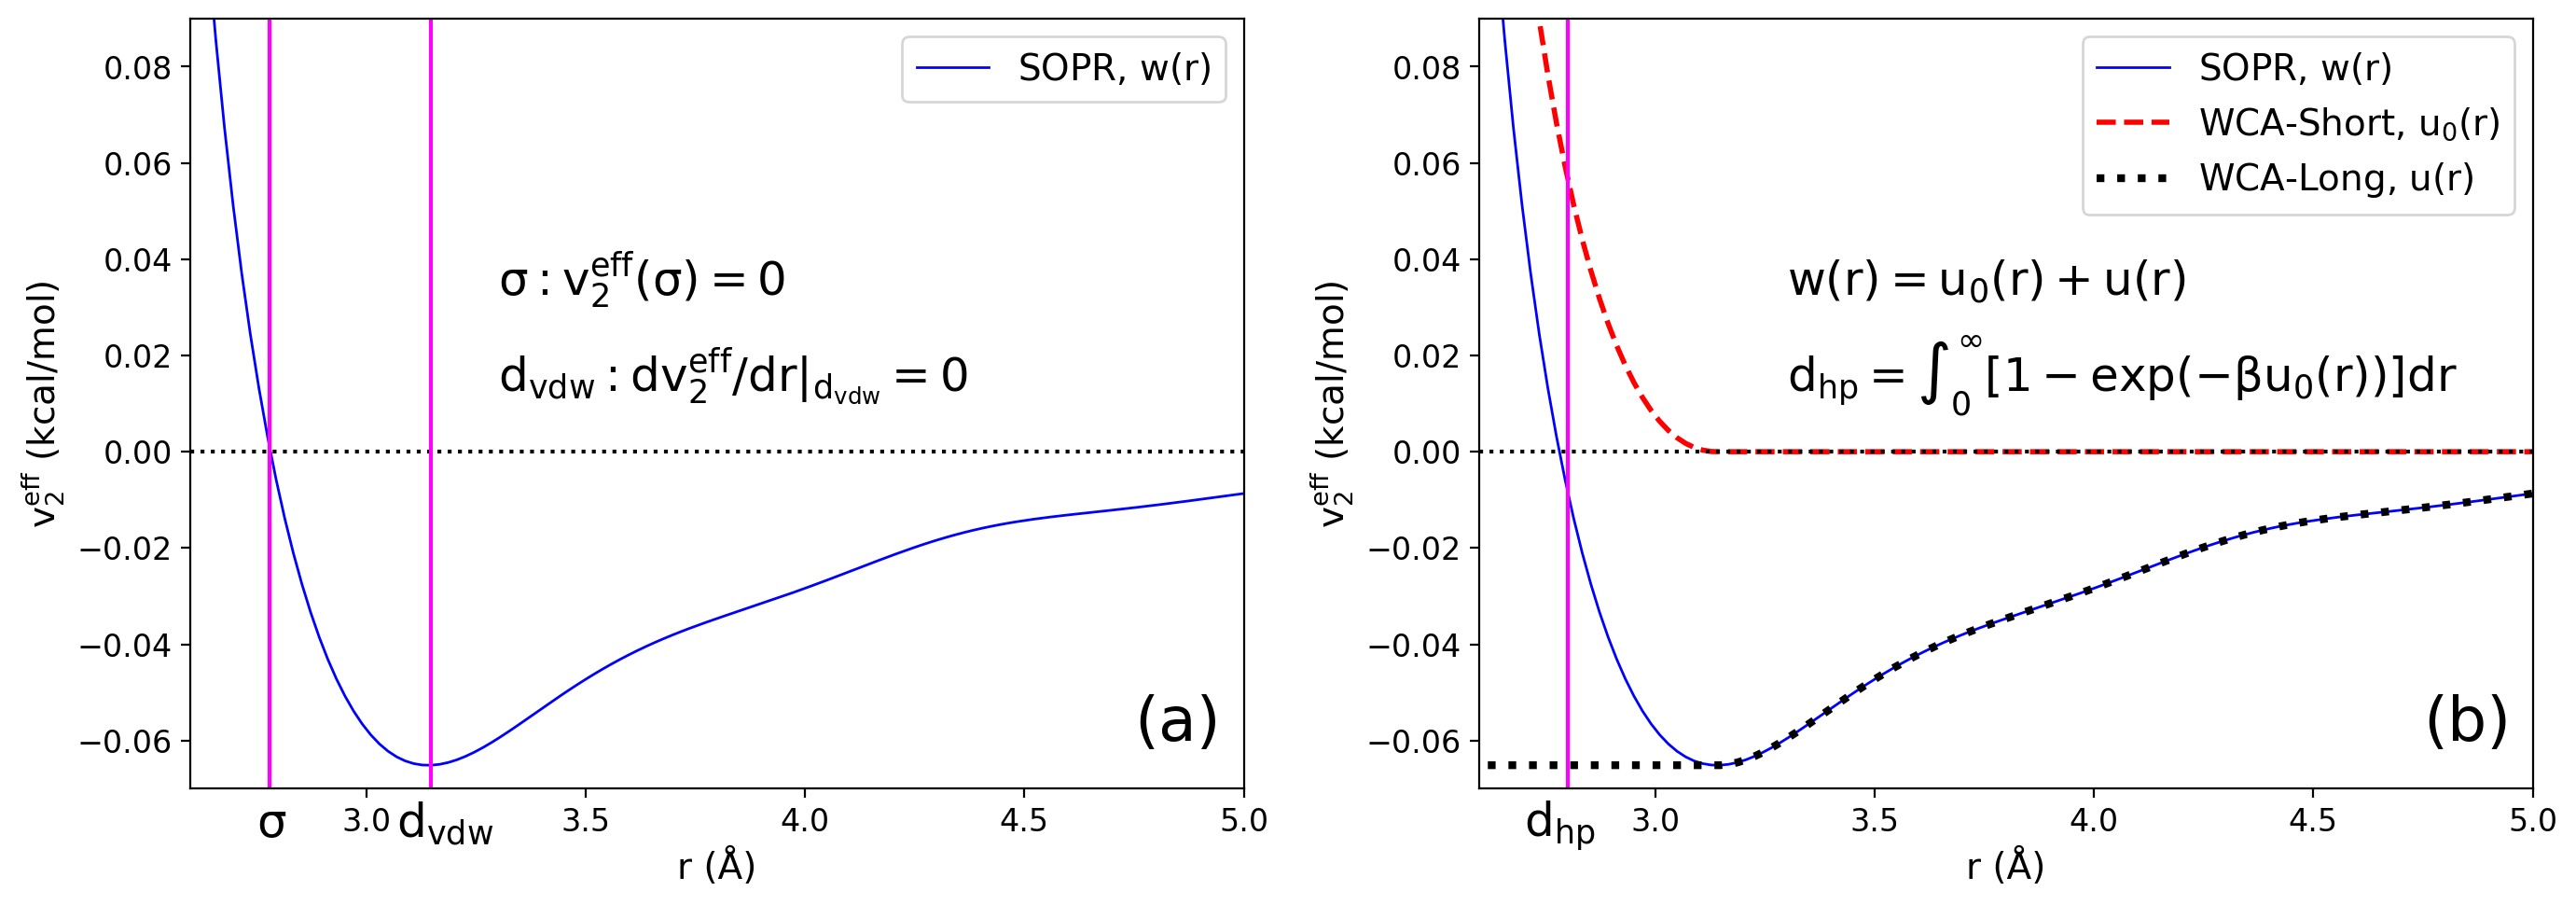

In [7]:
#figure to show particle size definitions and WCA decomposition
fig,ax = plt.subplots(1,2, figsize=(14,5))
ax[0].text(4.75,-0.06, '(a)', fontsize = 24)
ax[0].plot(r_ne, v_ne, color = 'b', label = 'SOPR, $w(r)$', linewidth = 1)
ax[0].text(2.75, -0.08, '$σ$', fontsize = 18)
ax[0].text(r_wca_ne - 0.08, -0.08, '$d_{vdw}$', fontsize = 18)
ax[0].text(3.3, 0.0325, '$\sigma : v_2^{eff}(σ) = 0$', fontsize = 18)
ax[0].text(3.3, 0.0125, '$d_{vdw}: dv_2^{eff}/dr|_{d_{vdw}} = 0$', fontsize = 18)
ax[0].set_xlabel('r (Å)', fontsize = 14)
ax[0].set_ylabel('$v_2^{eff}$ (kcal/mol)', fontsize = 14)
ax[0].set_xlim(2.6,5)
ax[0].set_ylim(-0.07,0.09)
ax[0].axhline(0, color = 'k', linestyle = ':')
ax[0].axvline(2.78, color = 'magenta')
ax[0].axvline(r_wca_ne, color = 'magenta')
ax[0].legend(fontsize = 14)

ax[1].text(4.75,-0.06, '(b)', fontsize = 24)
ax[1].plot(r_ne, v_ne, color = 'b', label = 'SOPR, $w(r)$', linewidth = 1)
ax[1].plot(r_ne, wca_ne, color = 'r', linestyle = '--', label = 'WCA-Short, $u_0(r)$', linewidth = 2)
ax[1].plot(r_ne, att_ne, color = 'k', linestyle = ':', label = 'WCA-Long, $u(r)$', linewidth = 3)
ax[1].axvline(hp_ne, color = 'magenta')
ax[1].axhline(0, color = 'k', linestyle = ':')
ax[1].set_xlim(2.6,5)
ax[1].set_ylim(-0.07,0.09)
ax[1].set_xlabel('r (Å)', fontsize = 14)
ax[1].set_ylabel('$v_2^{eff}$ (kcal/mol)', fontsize = 14)
ax[1].text(3.3, 0.0325, '$w(r) = u_0(r) + u(r)$', fontsize = 18)
ax[1].text(3.3, 0.0125, '$d_{hp} = \int_0^\infty [1 - \exp(-βu_0(r))]dr$', fontsize = 18)
ax[1].text(hp_ne-0.1, -0.08, '$d_{hp}$', fontsize = 18)
ax[1].legend(fontsize = 14)
plt.tight_layout()
plt.savefig('figures/wca_decomp', dpi = 600)
plt.show()

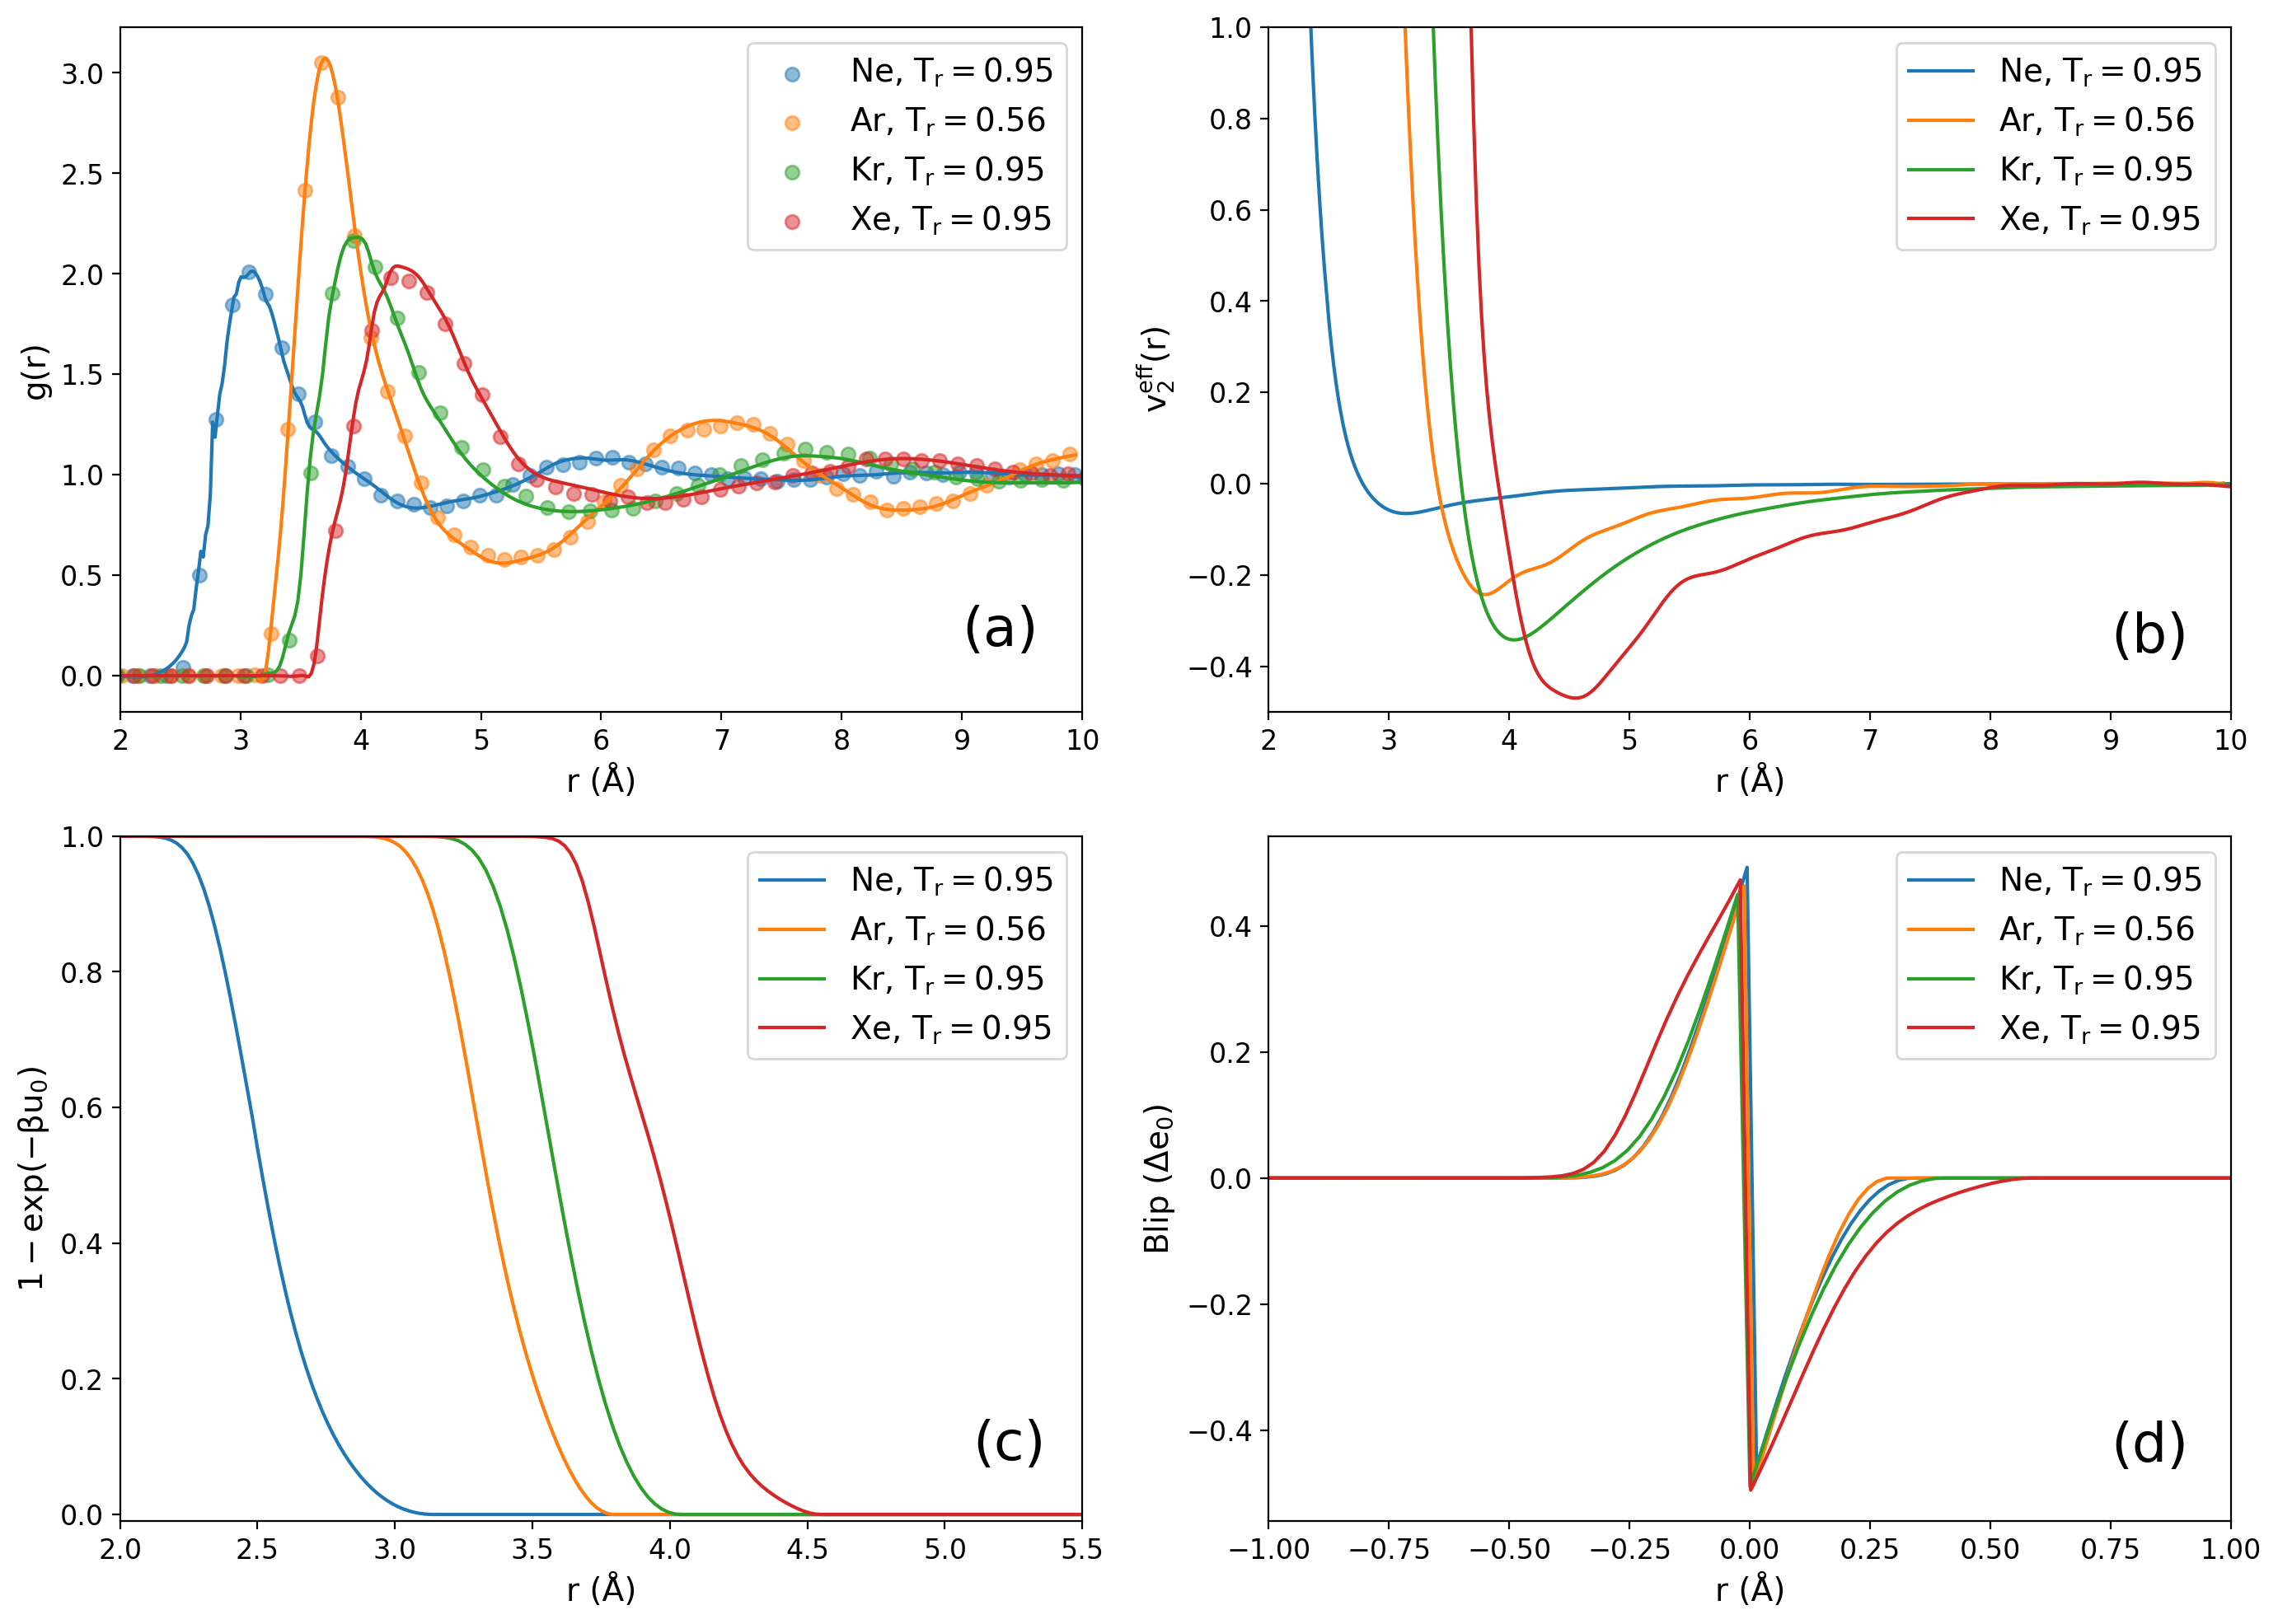

In [8]:
fig,ax = plt.subplots(2,2, figsize=(14,10))

ax[0,0].plot(ne_r_exp, ne_rdf_exp)
ax[0,0].scatter(r_ne[::7], ne_rdf_sopr[::7], label = 'Ne, $T_r = 0.95$', alpha = 0.5)
ax[0,0].plot(ar_r_exp, ar_rdf_exp)
ax[0,0].scatter(r_ar[::7], ar_rdf_sopr[::7], label = 'Ar, $T_r = 0.56$', alpha = 0.5)
ax[0,0].plot(kr_r_exp, kr_rdf_exp)
ax[0,0].scatter(r_kr[::7], kr_rdf_sopr[::7], label = 'Kr, $T_r = 0.95$', alpha = 0.5)
ax[0,0].plot(xe_r_exp, xe_rdf_exp)
ax[0,0].scatter(r_xe[::7], xe_rdf_sopr[::7], label = 'Xe, $T_r = 0.95$', alpha = 0.5)
ax[0,0].text(9,0.15, '(a)', fontsize = 24)
ax[0,0].set_xlim(2,10)
ax[0,0].set_xlabel('r (Å)', fontsize = 14)
ax[0,0].set_ylabel('g(r)', fontsize = 14)
ax[0,0].legend(fontsize = 14)

ax[0,1].plot(r_ne, v_ne, label = 'Ne, $T_r = 0.95$')
ax[0,1].plot(r_ar, v_ar, label = 'Ar, $T_r = 0.56$')
ax[0,1].plot(r_kr, v_kr, label = 'Kr, $T_r = 0.95$')
ax[0,1].plot(r_xe, v_xe, label = 'Xe, $T_r = 0.95$')
ax[0,1].set_xlim(2,10)
ax[0,1].set_ylim(-0.5,1)
ax[0,1].set_xlabel('r (Å)', fontsize = 14)
ax[0,1].set_ylabel('$v_2^{eff}(r)$', fontsize = 14)
ax[0,1].text(9,-0.37, '(b)', fontsize = 24)
ax[0,1].legend(fontsize = 14)

#figure to show hard-particle radius calculation
ax[1,0].plot(r_ne, 1-np.exp((-1/kbT)*np.array(wca_ne)), label = 'Ne, $T_r = 0.95$')
ax[1,0].plot(r_ar, 1-np.exp((-1/kbT)*np.array(wca_ar)), label = 'Ar, $T_r = 0.56$')
ax[1,0].plot(r_kr, 1-np.exp((-1/kbT)*np.array(wca_kr)), label = 'Kr, $T_r = 0.95$')
ax[1,0].plot(r_xe, 1-np.exp((-1/kbT)*np.array(wca_xe)), label = 'Xe, $T_r = 0.95$')
ax[1,0].set_xlim(2,5.5)
ax[1,0].set_ylim(-0.01,1)
ax[1,0].set_xlabel('r (Å)', fontsize = 14)
ax[1,0].set_ylabel('$1 - exp(-β u_0)$', fontsize = 14)
ax[1,0].text(5.1,0.08, '(c)', fontsize = 24)
ax[1,0].legend(fontsize = 14)

#figure to show hard-particle radius calculation
ax[1,1].plot(r_ne-hp_ne, blip_ne, label = 'Ne, $T_r = 0.95$')
ax[1,1].plot(r_ar-hp_ar, blip_ar, label = 'Ar, $T_r = 0.56$')
ax[1,1].plot(r_kr-hp_kr, blip_kr, label = 'Kr, $T_r = 0.95$')
ax[1,1].plot(r_xe-hp_xe, blip_xe, label = 'Xe, $T_r = 0.95$')
ax[1,1].set_xlim(-1,1)
ax[1,1].set_xlabel('r (Å)', fontsize = 14)
ax[1,1].set_ylabel('Blip (Δ$e_0$)', fontsize = 14)
ax[1,1].legend(fontsize = 14)
ax[1,1].text(0.75,-0.45, '(d)', fontsize = 24)
plt.tight_layout()
plt.savefig('figures/hard_particle', dpi = 600)
plt.show()

In [9]:
# linear fit for dispersion parameter
def line(p, m, b):
    return m*p + b
#learn σ QDO constant
x_data = np.log(α)
y_data = np.log(-disp)
params, params_covariance_sopr = curve_fit(line, x_data, y_data)
y_fit = line(x_data, *params)
ss_res = np.sum((y_data - y_fit) ** 2)
print(ss_res)
ss_tot = np.sum((y_data - np.mean(y_data)) ** 2)
r_squared = 1 - (ss_res / ss_tot)
print("σ QDO Parameter:", params)
print("R^2:", r_squared)

0.00933759511275905
σ QDO Parameter: [ 0.86450809 -1.90078644]
R^2: 0.9958647882626156


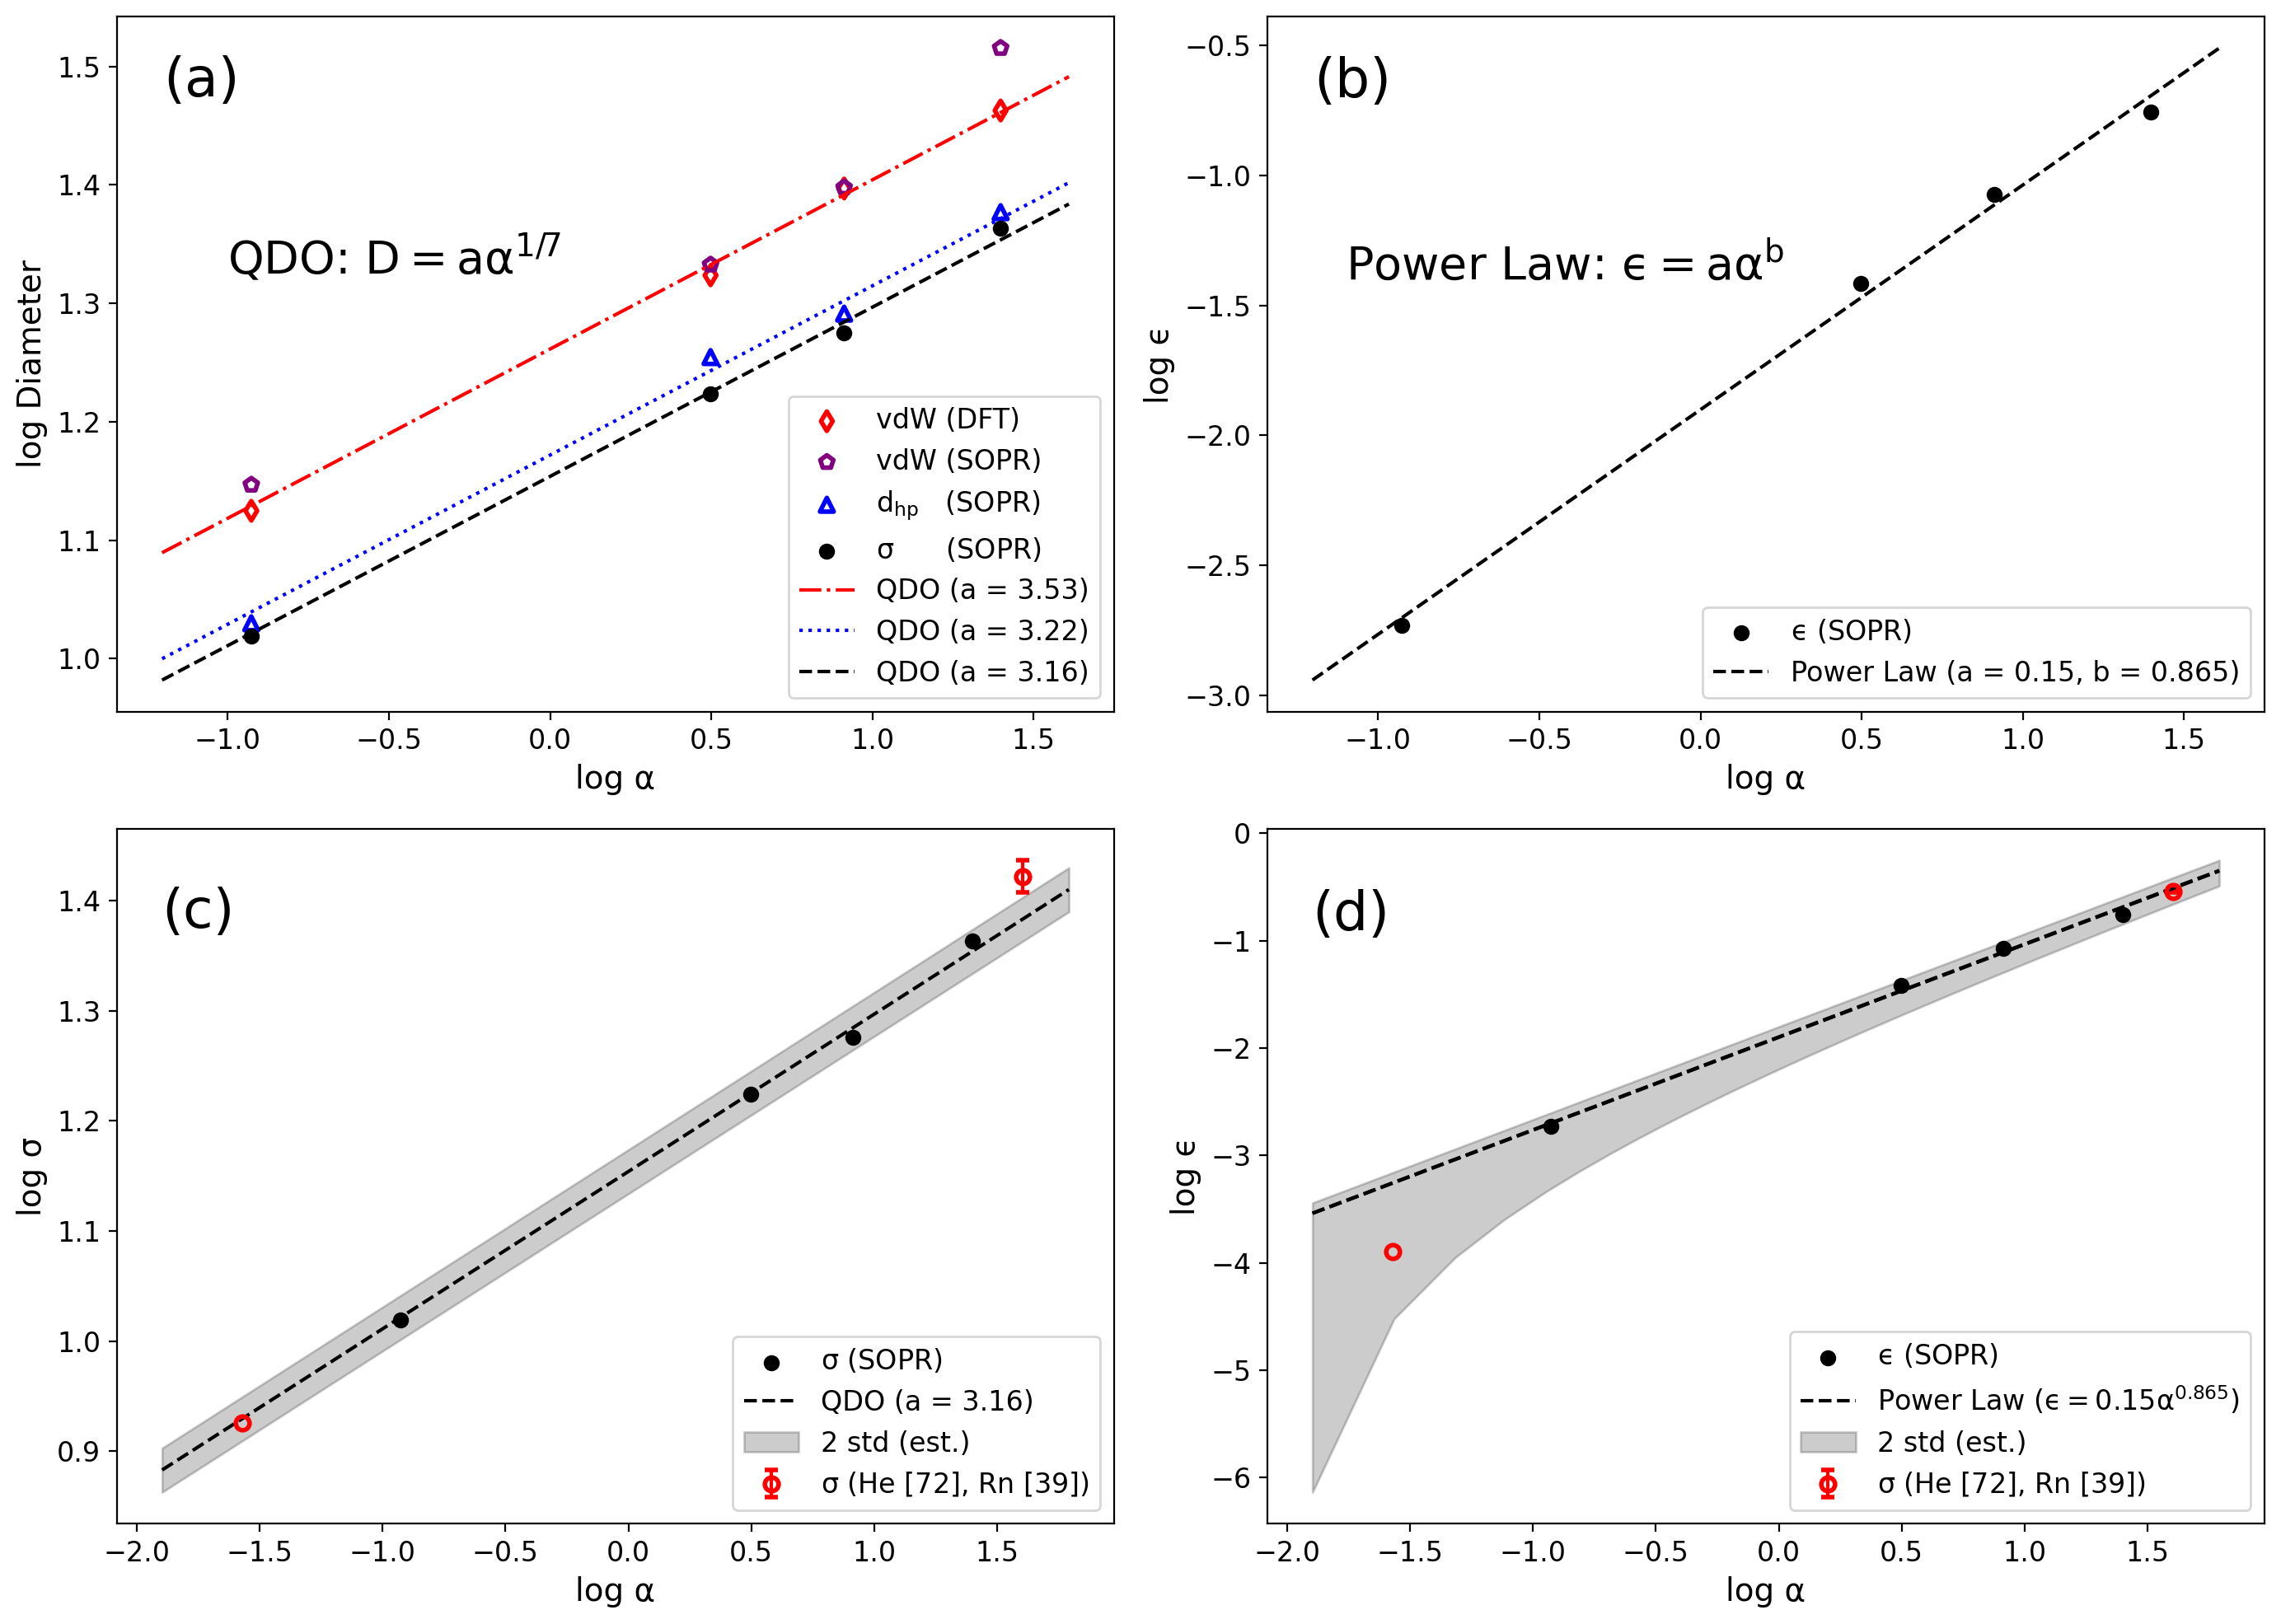

In [12]:
fig,ax = plt.subplots(2,2, figsize=(14,10))
ax[0,0].text(-1.2, 1.475, '(a)', fontsize = 24)
ax[0,0].text(-1, 1.325, 'QDO: $D = a α^{1/7}$', fontsize = 20)
α_lin = np.linspace(0.3, 5, 100)
ax[0,0].scatter(np.array(np.log(α)), np.log(2*r_vdw), color = 'r', label = 'vdW (DFT)', marker = 'd', facecolor = 'none', linewidth = 2)
ax[0,0].scatter(np.array(np.log(α)), np.log(sopr_vdW_radii), color = 'purple', label = 'vdW (SOPR)', marker = 'p', facecolor = 'none', linewidth = 2)
ax[0,0].scatter(np.log(α), np.log(hp),    color = 'b', label = '$d_{hp}$   (SOPR)', marker = '^', facecolor = 'none', linewidth = 2)
ax[0,0].scatter(np.log(α), np.log(r_sop),  color = 'k', label = '$\sigma$      (SOPR)')
ax[0,0].plot(np.log(α_lin), np.log(2*2.54*(1/.529)**(-4/7)*np.power(α_lin,1/7)), color = 'r', linestyle = '-.', label = 'QDO (a = 3.53)')
ax[0,0].plot(np.log(α_lin), np.log(params_hp*np.power(α_lin,1/7)), color = 'b', linestyle = ':', label = 'QDO (a = 3.22)')
ax[0,0].plot(np.log(α_lin), np.log(params_sopr*np.power(α_lin,1/7)), color = 'k', linestyle = '--', label = 'QDO (a = 3.16)')
ax[0,0].set_xlabel('log α', fontsize = 14)
ax[0,0].set_ylabel('log Diameter', fontsize = 14)
ax[0,0].legend(loc = 'lower right')

ax[0,1].text(-1.2, -0.7, '(b)', fontsize = 24)
ax[0,1].text(-1.1, -1.4, 'Power Law: $ϵ = a α^{b}$', fontsize = 20)
ax[0,1].scatter(np.log(α), np.log(-disp),  color = 'k', label = '$ϵ$ (SOPR)')
ax[0,1].plot(np.log(α_lin), line(np.log(α_lin), params[0], params[1]), color = 'k', label = 'Power Law (a = 0.15, b = 0.865)', linestyle = '--')
ax[0,1].set_xlabel('log α', fontsize = 14)
ax[0,1].set_ylabel('log ϵ', fontsize = 14)
ax[0,1].legend(loc = 'lower right')

p_10 = [np.nan, 0.01436]
p_90 = [np.nan, 0.01458]
yerr = [p_10, p_90]  # 'up' error
ax[1,0].text(-1.9, 1.375, '(c)', fontsize = 24)
α_lin = np.linspace(0.15, 6, 100)
ax[1,0].errorbar(np.log(atom_pola), np.log(ff_trained), yerr,  color = 'r', linestyle = '',
              label = '$\sigma$ (He [72], Rn [39])', markerfacecolor = 'none', marker = 'o', markeredgewidth = 2, capsize=3)

ax[1,0].scatter(np.log(α), np.log(r_sop),  color = 'k', label = '$\sigma$ (SOPR)')
ax[1,0].plot(np.log(α_lin), np.log(params_sopr*np.power(α_lin,1/7)), color = 'k', linestyle = '--', label = 'QDO (a = 3.16)')
ax[1,0].fill_between(np.log(α_lin), np.log(1.02*params_sopr*np.power(α_lin,1/7)), np.log(0.98*params_sopr*np.power(α_lin,1/7)), 
                   color = 'k', alpha = 0.2, label = '2 std (est.)')
ax[1,0].set_xlabel('log α', fontsize = 14)
ax[1,0].set_ylabel('log σ', fontsize = 14)
ax[1,0].legend(loc = 'lower right')

p_10 = [np.nan, 0.00683]
p_90 = [np.nan, 0.00687]
yerr = [p_10, p_90]  # 'up' error
ax[1,1].text(-1.9, -0.9, '(d)', fontsize = 24)
ax[1,1].errorbar(np.log(atom_pola), np.log(disp_ff), yerr,  color = 'r', linestyle = '', capsize=3,
              label = '$\sigma$ (He [72], Rn [39])', markerfacecolor = 'none', marker = 'o', markeredgewidth = 2)
ax[1,1].scatter(np.log(α), np.log(-disp),  color = 'k', label = '$ϵ$ (SOPR)')
ax[1,1].plot(np.log(α_lin), line(np.log(α_lin), params[0], params[1]), color = 'k', label = 'Power Law ($ϵ = 0.15 α^{0.865}$)', linestyle = '--')
ax[1,1].plot(np.log(α_lin), np.log(0.15*np.power(α_lin,0.865)), color = 'k', linestyle = '--')
ax[1,1].fill_between(np.log(α_lin), np.log(1.1*0.15*np.power(α_lin,0.865)), np.log(0.9*0.15*np.power(α_lin,0.865) - 0.024), 
                   color = 'k', alpha = 0.2, label = '2 std (est.)')
ax[1,1].set_xlabel('log α', fontsize = 14)
ax[1,1].set_ylabel('log ϵ', fontsize = 14)
ax[1,1].legend(loc = 'lower right')
plt.tight_layout()
plt.savefig('figures/noblegas_polar',dpi=600)
plt.show()

In [11]:
#Estimates for Og
og_ol = 57.98*(0.529177**3)  #bohr^3
og_σ  = 3.16*og_ol**(1/7)
og_ϵ  = 0.15*og_ol**(0.865)
print("Og α:", 57.98*(0.529177**3))
print("Og σ:", og_σ)
print("Og ϵ:", og_ϵ)

Og α: 8.591739298462844
Og σ: 4.296622896230273
Og ϵ: 0.9639875000050188
